In [7]:
import sys, os, time
from dotenv import load_dotenv
# adding the lates version of the osnap_client to the path
from pathlib import Path
file_path = Path(".").absolute()
sys.path.append(str(file_path.parent))
import json
# display the image
from PIL import Image
from io import BytesIO
import IPython.display
import discord
from osnap_client.adapters import DiscordAdapter
from osnap_client.agents import SwarmAgentBase
from osnap_client.protocol import AgentCommand, AgentCommandType
from osnap_client.utils.ai_engines import DalleEngine

In [8]:
load_dotenv()

True

In [15]:
dalle_engine = DalleEngine()

In [16]:
prompt = "cute cat"
image = dalle_engine.imagine(prompt)

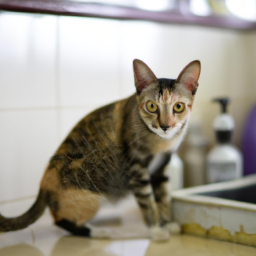

In [30]:
with BytesIO() as image_binary:
    image_binary.write(image)
    image_binary.seek(0)
    file = discord.File(image_binary)
    img = Image.open(image_binary)
    IPython.display.display(img)

# close the io stream
#image_binary.close()

In [31]:
file

In [32]:
response = AgentCommand(
    sender="aaa",
    receiver="agent",
    command_type=AgentCommandType.SUBMIT,
    task_name="imagine",
    payload_type = 'bytes/latin-1',
    payload=image.decode('latin-1'),
)

In [33]:
xxx = response.json()

In [37]:
xxx = json.loads(xxx)

In [38]:
image = xxx['payload'].encode('latin-1')

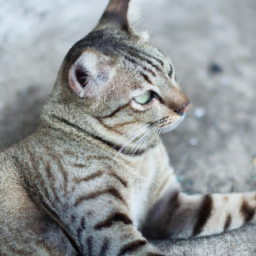